In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import sys
import torch
# Does this fix the hdf5 multiprocessing bug?
torch.multiprocessing.set_start_method("spawn")

# !git clone https://github.com/guydav/deep-learning-projects.git
# !pip install -q -r deep-learning-projects/requirements.txt
!wandb login 9676e3cc95066e4865586082971f2653245f09b4
sys.path.extend(('/home/cc/deep-learning-projects', '/home/cc/src/tqdm'))

Appending key for api.wandb.ai to your netrc file: /home/cc/.netrc
Successfully logged in to Weights & Biases!


In [4]:
import projects
from projects.metalearning import *

## Load the dataset

This time with 3x the batch size, 1.5k

In [7]:
ML_50K = '/home/cc/meta_learning_50k.h5'

benchmark_dimension = 1
dataset_random_seed = 33
train_coreset_size = 22500
test_coreset_size = 5000
shared_train_coreset = True

np.random.seed(33)
query_order = np.arange(10) + benchmark_dimension * 10
np.random.shuffle(query_order)
accuracy_threshold = 0.95

normalized_train_dataset, train_dataloader, normalized_test_dataset, test_dataloader = \
        create_normalized_datasets(dataset_path=ML_50K, 
                                   batch_size=1500,
                                   num_workers=4,
                                   downsample_size=None,
                                   should_flip=False,
                                   return_indices=False,
                                   dataset_class=SequentialBenchmarkMetaLearningDataset,
                                   dataset_class_kwargs=dict(
                                       benchmark_dimension=benchmark_dimension,
                                       random_seed=dataset_random_seed,
                                       query_order=query_order
                                   ),
                                   train_dataset_kwargs=dict(
                                       previous_query_coreset_size=train_coreset_size,
                                       coreset_size_shared=shared_train_coreset,
                                   ),
                                   test_dataset_kwargs=dict(previous_query_coreset_size=test_coreset_size))

Splitting test-train at 45000
Loaded normalization from cache
[0.4644661  0.45839542 0.45069984]
[0.11204559 0.11298621 0.12539756]


In [8]:
current_epoch = 0
save_dir = '/home/cc/checkpoints'

sequential_benchmark_test_model = PoolingDropoutCNNMLP(
    query_length=30,
    conv_filter_sizes=(16, 32, 48, 64),
    conv_output_size=4480, 
    mlp_layer_sizes=(512, 512, 512, 512),
    lr=5e-4,
    weight_decay=0, # 1e-4,
    lr_scheduler_patience=100,
    conv_dropout=False,
    mlp_dropout=False,
    name='no_dropout_no_decay_sequential_benchmark_v1_coreset_15k_second_dimension',
    save_dir=save_dir)

sequential_benchmark_test_model.load_model(current_epoch)
sequential_benchmark_test_model = sequential_benchmark_test_model.cuda()

512


In [9]:
# os.environ['WANDB_RUN_ID'] ='98w3kzlw'
# os.environ['WANDB_RESUME'] = 'must'
wandb.init(entity='meta-learning-scaling', project='sequential-benchmark')

wandb.run.description = '9k shared coreset, shape dimension, threshold current query only''
wandb.run.save()

current_model = sequential_benchmark_test_model

wandb.config.lr = current_model.lr
wandb.config.decay = current_model.weight_decay
wandb.config.loss = 'CE'
wandb.config.batch_size = train_dataloader.batch_size
wandb.config.benchmark_dimension = benchmark_dimension
wandb.config.dataset_random_seed = dataset_random_seed
wandb.config.train_coreset_size = train_coreset_size
wandb.config.test_coreset_size = test_coreset_size
wandb.config.query_order = [int(x) for x in query_order]
wandb.config.accuracy_threshold = accuracy_threshold

W&B Run: https://app.wandb.ai/meta-learning-scaling/sequential-benchmark/runs/elohyghn
Call `%%wandb` in the cell containing your training loop to display live results.


2019-02-10 19:43:12: After epoch 1, TRAIN acc is 54.5711, loss is 0.6845, AUC is 0.5137
2019-02-10 19:44:11: After epoch 1, TEST acc is 54.9200, loss is 0.6839, AUC is 0.5155
2019-02-10 19:54:39: After epoch 2, TRAIN acc is 55.5033, loss is 0.6805, AUC is 0.5367
2019-02-10 19:55:37: After epoch 2, TEST acc is 56.1700, loss is 0.6711, AUC is 0.5304
2019-02-10 20:05:59: After epoch 3, TRAIN acc is 58.0522, loss is 0.6453, AUC is 0.5590
2019-02-10 20:06:57: After epoch 3, TEST acc is 59.5800, loss is 0.6220, AUC is 0.5727
2019-02-10 20:17:20: After epoch 4, TRAIN acc is 60.6511, loss is 0.6072, AUC is 0.5865
2019-02-10 20:18:18: After epoch 4, TEST acc is 61.6600, loss is 0.5935, AUC is 0.5974
2019-02-10 20:28:42: After epoch 5, TRAIN acc is 62.6322, loss is 0.5815, AUC is 0.6066
2019-02-10 20:29:41: After epoch 5, TEST acc is 63.6100, loss is 0.5652, AUC is 0.6232
2019-02-10 20:40:10: After epoch 6, TRAIN acc is 64.3011, loss is 0.5516, AUC is 0.6252
2019-02-10 20:41:11: After epoch 6, T

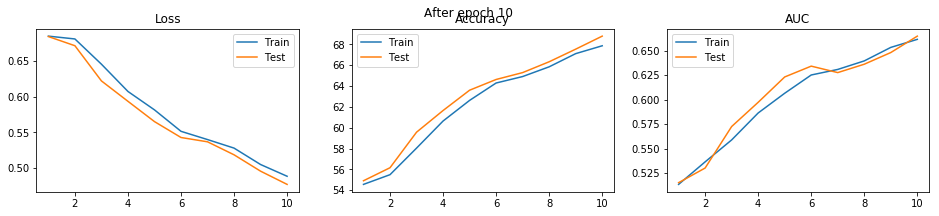

2019-02-10 21:37:17: After epoch 11, TRAIN acc is 69.1533, loss is 0.4668, AUC is 0.6748
2019-02-10 21:38:15: After epoch 11, TEST acc is 69.2500, loss is 0.4634, AUC is 0.6902
2019-02-10 21:48:39: After epoch 12, TRAIN acc is 69.3522, loss is 0.4608, AUC is 0.6768
2019-02-10 21:49:35: After epoch 12, TEST acc is 69.4100, loss is 0.4606, AUC is 0.6787
2019-02-10 21:59:59: After epoch 13, TRAIN acc is 69.4478, loss is 0.4595, AUC is 0.6780
2019-02-10 22:00:57: After epoch 13, TEST acc is 69.3800, loss is 0.4596, AUC is 0.6747
2019-02-10 22:11:22: After epoch 14, TRAIN acc is 69.4311, loss is 0.4588, AUC is 0.6781
2019-02-10 22:12:20: After epoch 14, TEST acc is 69.4000, loss is 0.4604, AUC is 0.6663
2019-02-10 22:22:46: After epoch 15, TRAIN acc is 69.4411, loss is 0.4585, AUC is 0.6788
2019-02-10 22:34:13: After epoch 16, TRAIN acc is 69.5356, loss is 0.4582, AUC is 0.6792
2019-02-10 22:35:11: After epoch 16, TEST acc is 69.8800, loss is 0.4582, AUC is 0.6806
2019-02-10 22:45:40: After

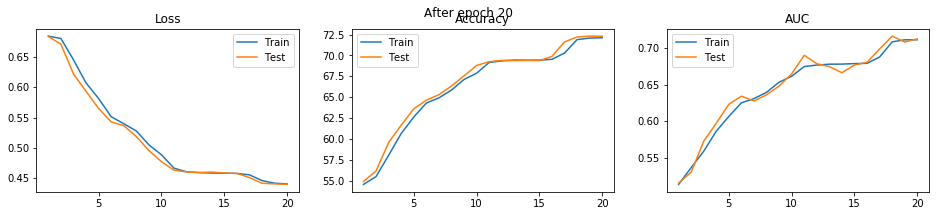

2019-02-10 23:31:16: After epoch 21, TRAIN acc is 73.2300, loss is 0.4234, AUC is 0.7214
2019-02-10 23:42:41: After epoch 22, TRAIN acc is 74.9367, loss is 0.3968, AUC is 0.7383
2019-02-10 23:43:40: After epoch 22, TEST acc is 76.1000, loss is 0.3845, AUC is 0.7539
2019-02-10 23:54:05: After epoch 23, TRAIN acc is 76.7056, loss is 0.3719, AUC is 0.7582
2019-02-10 23:55:06: After epoch 23, TEST acc is 77.5300, loss is 0.3593, AUC is 0.7621
2019-02-11 00:05:32: After epoch 24, TRAIN acc is 77.8378, loss is 0.3512, AUC is 0.7703
2019-02-11 00:06:33: After epoch 24, TEST acc is 78.1300, loss is 0.3483, AUC is 0.7690
2019-02-11 00:16:58: After epoch 25, TRAIN acc is 78.6111, loss is 0.3377, AUC is 0.7790
2019-02-11 00:17:58: After epoch 25, TEST acc is 79.5100, loss is 0.3254, AUC is 0.7883
2019-02-11 00:28:24: After epoch 26, TRAIN acc is 79.6578, loss is 0.3180, AUC is 0.7903
2019-02-11 00:29:22: After epoch 26, TEST acc is 79.9000, loss is 0.3144, AUC is 0.7930
2019-02-11 00:39:49: After

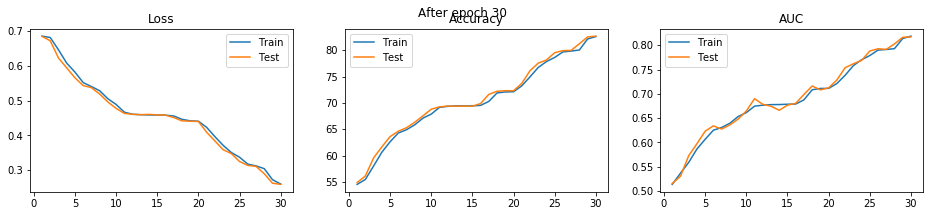

2019-02-11 01:25:22: After epoch 31, TRAIN acc is 82.6200, loss is 0.2590, AUC is 0.8194
2019-02-11 01:26:20: After epoch 31, TEST acc is 82.6800, loss is 0.2601, AUC is 0.8235
2019-02-11 01:36:44: After epoch 32, TRAIN acc is 82.6522, loss is 0.2584, AUC is 0.8203
2019-02-11 01:37:43: After epoch 32, TEST acc is 82.6400, loss is 0.2590, AUC is 0.8211
2019-02-11 01:48:09: After epoch 33, TRAIN acc is 82.6878, loss is 0.2582, AUC is 0.8203
2019-02-11 01:49:06: After epoch 33, TEST acc is 82.7400, loss is 0.2595, AUC is 0.8194
2019-02-11 01:59:31: After epoch 34, TRAIN acc is 82.7122, loss is 0.2573, AUC is 0.8211
2019-02-11 02:00:30: After epoch 34, TEST acc is 82.8000, loss is 0.2578, AUC is 0.8225
2019-02-11 02:10:56: After epoch 35, TRAIN acc is 82.7811, loss is 0.2572, AUC is 0.8224
2019-02-11 02:11:55: After epoch 35, TEST acc is 82.7500, loss is 0.2586, AUC is 0.8278
2019-02-11 02:22:22: After epoch 36, TRAIN acc is 82.8000, loss is 0.2563, AUC is 0.8231
2019-02-11 02:23:20: After

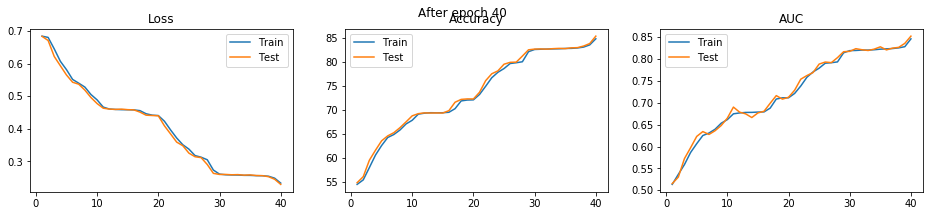

2019-02-11 03:19:32: After epoch 41, TRAIN acc is 85.7489, loss is 0.2241, AUC is 0.8570
2019-02-11 03:20:29: After epoch 41, TEST acc is 85.8100, loss is 0.2233, AUC is 0.8596
2019-02-11 03:30:57: After epoch 42, TRAIN acc is 86.1756, loss is 0.2159, AUC is 0.8609
2019-02-11 03:31:59: After epoch 42, TEST acc is 86.2400, loss is 0.2150, AUC is 0.8614
2019-02-11 03:42:27: After epoch 43, TRAIN acc is 86.2778, loss is 0.2120, AUC is 0.8621
2019-02-11 03:43:24: After epoch 43, TEST acc is 86.2000, loss is 0.2131, AUC is 0.8640
2019-02-11 03:54:49: After epoch 44, TEST acc is 86.3200, loss is 0.2115, AUC is 0.8659
2019-02-11 04:05:17: After epoch 45, TRAIN acc is 86.3844, loss is 0.2092, AUC is 0.8631
2019-02-11 04:06:15: After epoch 45, TEST acc is 86.3300, loss is 0.2104, AUC is 0.8593
2019-02-11 04:16:44: After epoch 46, TRAIN acc is 86.4200, loss is 0.2089, AUC is 0.8634
2019-02-11 04:17:43: After epoch 46, TEST acc is 86.3100, loss is 0.2119, AUC is 0.8630
2019-02-11 04:28:10: After 

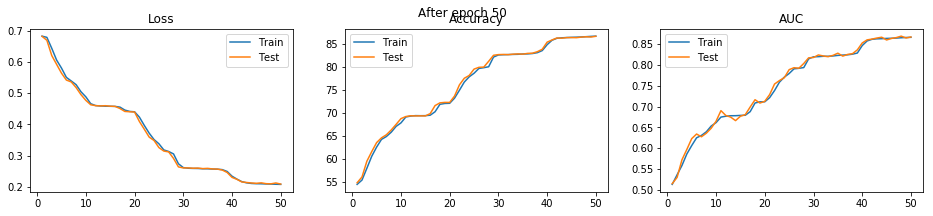

2019-02-11 05:13:44: After epoch 51, TRAIN acc is 86.7333, loss is 0.2063, AUC is 0.8667
2019-02-11 05:14:40: After epoch 51, TEST acc is 86.5800, loss is 0.2074, AUC is 0.8690
2019-02-11 05:25:07: After epoch 52, TRAIN acc is 86.8033, loss is 0.2054, AUC is 0.8678
2019-02-11 05:26:06: After epoch 52, TEST acc is 86.7600, loss is 0.2071, AUC is 0.8648
2019-02-11 05:36:33: After epoch 53, TRAIN acc is 86.8689, loss is 0.2046, AUC is 0.8682
2019-02-11 05:37:32: After epoch 53, TEST acc is 86.9200, loss is 0.2054, AUC is 0.8674
2019-02-11 05:48:00: After epoch 54, TRAIN acc is 87.0533, loss is 0.2022, AUC is 0.8696
2019-02-11 05:48:58: After epoch 54, TEST acc is 87.2100, loss is 0.2008, AUC is 0.8695
2019-02-11 05:59:26: After epoch 55, TRAIN acc is 87.6989, loss is 0.1930, AUC is 0.8763
2019-02-11 06:00:25: After epoch 55, TEST acc is 87.9800, loss is 0.1895, AUC is 0.8766
2019-02-11 06:10:51: After epoch 56, TRAIN acc is 88.4411, loss is 0.1846, AUC is 0.8855
2019-02-11 06:11:49: After

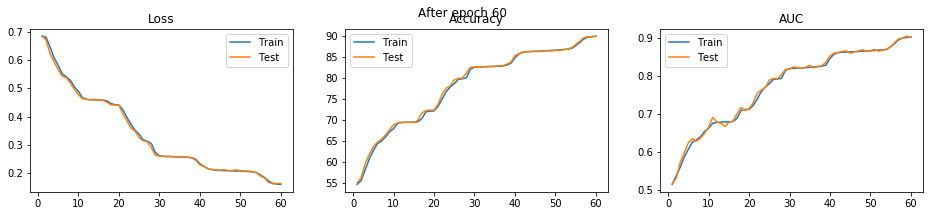

2019-02-11 07:07:56: After epoch 61, TRAIN acc is 90.1667, loss is 0.1589, AUC is 0.9039
2019-02-11 07:08:55: After epoch 61, TEST acc is 90.1300, loss is 0.1609, AUC is 0.9029
2019-02-11 07:19:17: After epoch 62, TRAIN acc is 90.2478, loss is 0.1577, AUC is 0.9051
2019-02-11 07:20:15: After epoch 62, TEST acc is 90.2100, loss is 0.1609, AUC is 0.9032
2019-02-11 07:30:36: After epoch 63, TRAIN acc is 90.4067, loss is 0.1565, AUC is 0.9067
2019-02-11 07:31:33: After epoch 63, TEST acc is 90.4600, loss is 0.1582, AUC is 0.9072
2019-02-11 07:41:57: After epoch 64, TRAIN acc is 90.7322, loss is 0.1532, AUC is 0.9102
2019-02-11 07:42:54: After epoch 64, TEST acc is 90.8900, loss is 0.1530, AUC is 0.9098
2019-02-11 07:53:17: After epoch 65, TRAIN acc is 91.0856, loss is 0.1471, AUC is 0.9141
2019-02-11 07:54:15: After epoch 65, TEST acc is 91.2000, loss is 0.1470, AUC is 0.9174
2019-02-11 08:04:39: After epoch 66, TRAIN acc is 91.2633, loss is 0.1438, AUC is 0.9158
2019-02-11 08:05:38: After

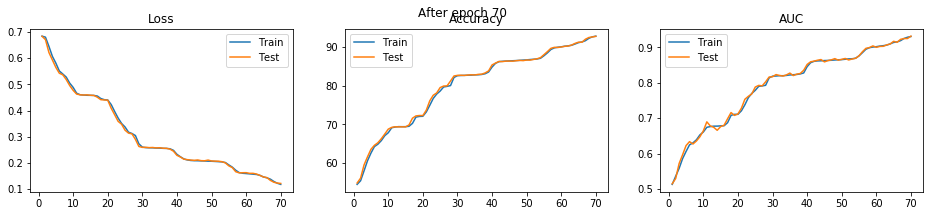

2019-02-11 09:01:52: After epoch 71, TRAIN acc is 92.8444, loss is 0.1166, AUC is 0.9318
2019-02-11 09:02:51: After epoch 71, TEST acc is 92.6000, loss is 0.1222, AUC is 0.9305
2019-02-11 09:13:17: After epoch 72, TRAIN acc is 92.9278, loss is 0.1148, AUC is 0.9327
2019-02-11 09:14:16: After epoch 72, TEST acc is 92.7900, loss is 0.1190, AUC is 0.9301
2019-02-11 09:24:45: After epoch 73, TRAIN acc is 93.0167, loss is 0.1136, AUC is 0.9336
2019-02-11 09:25:43: After epoch 73, TEST acc is 92.9800, loss is 0.1157, AUC is 0.9315
2019-02-11 09:36:06: After epoch 74, TRAIN acc is 93.1233, loss is 0.1126, AUC is 0.9345
2019-02-11 09:37:06: After epoch 74, TEST acc is 93.0400, loss is 0.1153, AUC is 0.9334
2019-02-11 09:47:37: After epoch 75, TRAIN acc is 93.2078, loss is 0.1112, AUC is 0.9356
2019-02-11 09:48:36: After epoch 75, TEST acc is 92.9600, loss is 0.1163, AUC is 0.9300
2019-02-11 09:59:00: After epoch 76, TRAIN acc is 93.4089, loss is 0.1099, AUC is 0.9373
2019-02-11 09:59:59: After

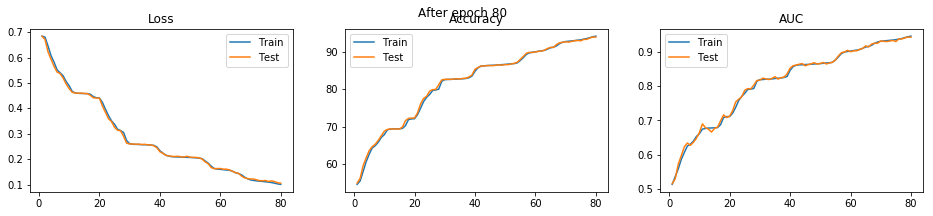

2019-02-11 10:55:59: After epoch 81, TRAIN acc is 94.3278, loss is 0.0992, AUC is 0.9473
2019-02-11 10:56:55: After epoch 81, TEST acc is 94.0300, loss is 0.1061, AUC is 0.9429
2019-02-11 11:07:24: After epoch 82, TRAIN acc is 94.6367, loss is 0.0950, AUC is 0.9501
2019-02-11 11:08:22: After epoch 82, TEST acc is 94.6100, loss is 0.0975, AUC is 0.9482
2019-02-11 11:18:49: After epoch 83, TRAIN acc is 95.0778, loss is 0.0867, AUC is 0.9547
2019-02-11 11:19:47: After epoch 83, TEST acc is 94.9200, loss is 0.0902, AUC is 0.9530
2019-02-11 11:30:11: After epoch 84, TRAIN acc is 95.3089, loss is 0.0833, AUC is 0.9569
2019-02-11 11:31:08: After epoch 84, TEST acc is 95.1300, loss is 0.0885, AUC is 0.9553
2019-02-11 11:41:31: After epoch 85, TRAIN acc is 95.4111, loss is 0.0808, AUC is 0.9581
2019-02-11 11:42:28: After epoch 85, TEST acc is 95.1500, loss is 0.0881, AUC is 0.9560
2019-02-11 11:52:54: After epoch 86, TRAIN acc is 95.5778, loss is 0.0782, AUC is 0.9598
2019-02-11 11:53:51: After

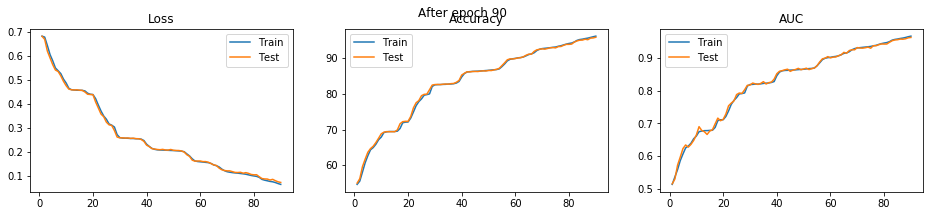

2019-02-11 12:49:52: After epoch 91, TRAIN acc is 96.4289, loss is 0.0620, AUC is 0.9686
2019-02-11 12:50:51: After epoch 91, TEST acc is 95.9900, loss is 0.0724, AUC is 0.9656
2019-02-11 13:01:19: After epoch 92, TRAIN acc is 96.5633, loss is 0.0590, AUC is 0.9701
2019-02-11 13:02:17: After epoch 92, TEST acc is 96.1600, loss is 0.0686, AUC is 0.9669
2019-02-11 13:12:45: After epoch 93, TRAIN acc is 96.7022, loss is 0.0562, AUC is 0.9713
2019-02-11 13:13:43: After epoch 93, TEST acc is 96.3800, loss is 0.0640, AUC is 0.9683
2019-02-11 13:24:10: After epoch 94, TRAIN acc is 96.7722, loss is 0.0537, AUC is 0.9720
2019-02-11 13:25:10: After epoch 94, TEST acc is 96.2600, loss is 0.0662, AUC is 0.9673
2019-02-11 13:35:37: After epoch 95, TRAIN acc is 96.8544, loss is 0.0516, AUC is 0.9728
2019-02-11 13:36:34: After epoch 95, TEST acc is 96.4100, loss is 0.0636, AUC is 0.9691
2019-02-11 13:46:58: After epoch 96, TRAIN acc is 96.9211, loss is 0.0509, AUC is 0.9735
2019-02-11 13:47:56: After

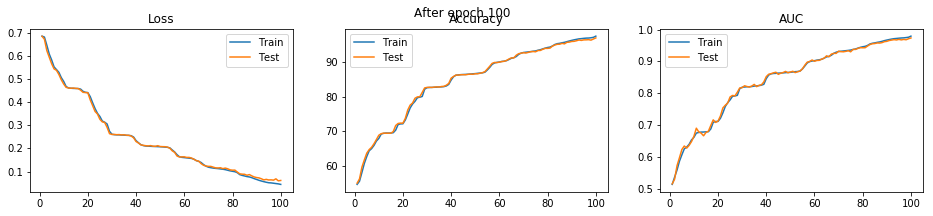

2019-02-11 14:43:59: After epoch 101, TRAIN acc is 98.0489, loss is 0.0374, AUC is 0.9852
2019-02-11 14:44:58: After epoch 101, TEST acc is 97.5100, loss is 0.0534, AUC is 0.9791
2019-02-11 14:55:27: After epoch 102, TRAIN acc is 98.4067, loss is 0.0298, AUC is 0.9888
2019-02-11 14:56:24: After epoch 102, TEST acc is 97.8800, loss is 0.0459, AUC is 0.9831
2019-02-11 15:06:43: After epoch 103, TRAIN acc is 98.6478, loss is 0.0259, AUC is 0.9904
2019-02-11 15:07:37: After epoch 103, TEST acc is 97.9200, loss is 0.0449, AUC is 0.9836
2019-02-11 15:17:55: After epoch 104, TRAIN acc is 98.7544, loss is 0.0236, AUC is 0.9913
2019-02-11 15:18:49: After epoch 104, TEST acc is 98.0000, loss is 0.0428, AUC is 0.9839
2019-02-11 15:29:08: After epoch 105, TRAIN acc is 98.8267, loss is 0.0224, AUC is 0.9918
2019-02-11 15:30:02: After epoch 105, TEST acc is 98.0100, loss is 0.0408, AUC is 0.9855
2019-02-11 15:40:21: After epoch 106, TRAIN acc is 98.8822, loss is 0.0206, AUC is 0.9925
2019-02-11 15:4

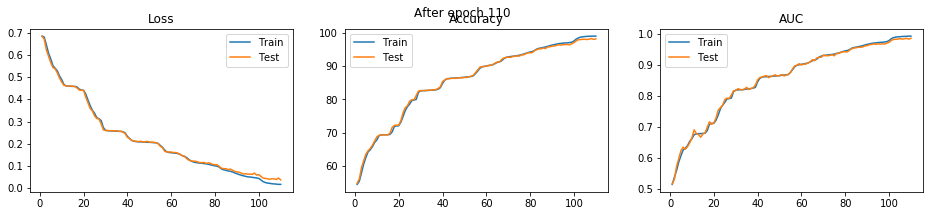

2019-02-11 16:36:27: After epoch 111, TRAIN acc is 98.9667, loss is 0.0168, AUC is 0.9940
2019-02-11 16:37:23: After epoch 111, TEST acc is 97.9500, loss is 0.0509, AUC is 0.9838
2019-02-11 16:47:41: After epoch 112, TRAIN acc is 98.9767, loss is 0.0164, AUC is 0.9941
2019-02-11 16:48:36: After epoch 112, TEST acc is 98.1200, loss is 0.0399, AUC is 0.9858
2019-02-11 16:58:51: After epoch 113, TRAIN acc is 98.9778, loss is 0.0159, AUC is 0.9944
2019-02-11 16:59:46: After epoch 113, TEST acc is 98.1000, loss is 0.0405, AUC is 0.9864
2019-02-11 17:10:04: After epoch 114, TRAIN acc is 98.9789, loss is 0.0153, AUC is 0.9946
2019-02-11 17:11:01: After epoch 114, TEST acc is 98.1100, loss is 0.0417, AUC is 0.9860
2019-02-11 17:21:20: After epoch 115, TRAIN acc is 98.9911, loss is 0.0148, AUC is 0.9948
2019-02-11 17:22:14: After epoch 115, TEST acc is 98.0900, loss is 0.0410, AUC is 0.9858
2019-02-11 17:32:31: After epoch 116, TRAIN acc is 98.9744, loss is 0.0153, AUC is 0.9946
Epoch   115: re

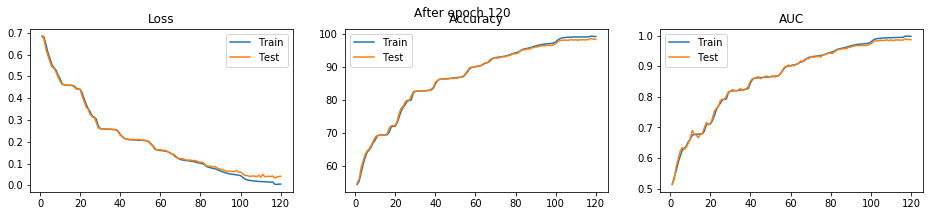

2019-02-11 18:28:34: After epoch 121, TRAIN acc is 99.1211, loss is 0.0054, AUC is 0.9984
2019-02-11 18:29:29: After epoch 121, TEST acc is 98.4100, loss is 0.0389, AUC is 0.9886
2019-02-11 18:39:48: After epoch 122, TRAIN acc is 99.1489, loss is 0.0051, AUC is 0.9985
2019-02-11 18:40:46: After epoch 122, TEST acc is 98.2600, loss is 0.0438, AUC is 0.9873
2019-02-11 18:51:11: After epoch 123, TRAIN acc is 99.1267, loss is 0.0053, AUC is 0.9984
Epoch   122: reducing learning rate of group 0 to 1.2500e-04.
2019-02-11 18:52:08: After epoch 123, TEST acc is 98.1500, loss is 0.0460, AUC is 0.9867
2019-02-11 19:02:32: After epoch 124, TRAIN acc is 99.6311, loss is 0.0022, AUC is 0.9996
2019-02-11 19:03:30: After epoch 124, TEST acc is 98.5100, loss is 0.0352, AUC is 0.9896
2019-02-11 19:13:56: After epoch 125, TRAIN acc is 99.8722, loss is 0.0014, AUC is 0.9999
2019-02-11 19:14:53: After epoch 125, TEST acc is 98.5800, loss is 0.0348, AUC is 0.9899
2019-02-11 19:25:19: After epoch 126, TRAIN

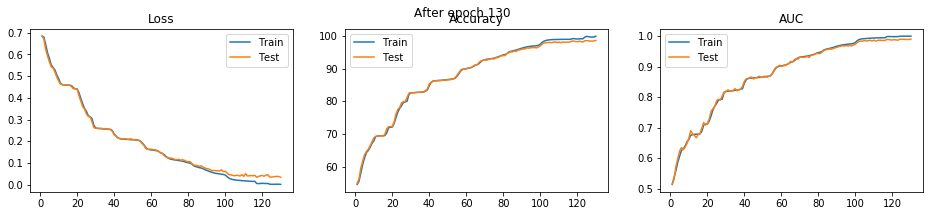

2019-02-11 20:22:09: After epoch 131, TRAIN acc is 99.9844, loss is 0.0010, AUC is 1.0000
2019-02-11 20:23:07: After epoch 131, TEST acc is 98.6400, loss is 0.0335, AUC is 0.9903
2019-02-11 20:33:38: After epoch 132, TRAIN acc is 99.9844, loss is 0.0011, AUC is 1.0000
2019-02-11 20:45:02: After epoch 133, TRAIN acc is 99.9589, loss is 0.0012, AUC is 1.0000
2019-02-11 20:46:02: After epoch 133, TEST acc is 98.5600, loss is 0.0356, AUC is 0.9898
2019-02-11 20:56:30: After epoch 134, TRAIN acc is 99.9456, loss is 0.0012, AUC is 1.0000
2019-02-11 20:57:28: After epoch 134, TEST acc is 98.6200, loss is 0.0343, AUC is 0.9902
2019-02-11 21:07:53: After epoch 135, TRAIN acc is 99.9500, loss is 0.0012, AUC is 1.0000
2019-02-11 21:08:49: After epoch 135, TEST acc is 98.6200, loss is 0.0356, AUC is 0.9901
2019-02-11 21:19:08: After epoch 136, TRAIN acc is 99.9589, loss is 0.0011, AUC is 1.0000
2019-02-11 21:20:06: After epoch 136, TEST acc is 98.5700, loss is 0.0363, AUC is 0.9897
Epoch   136: re

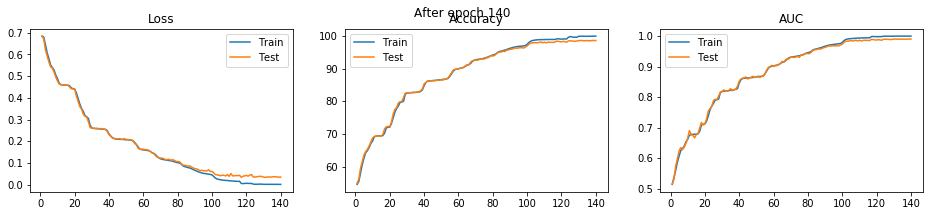

2019-02-11 22:16:08: After epoch 141, TRAIN acc is 99.9956, loss is 0.0009, AUC is 1.0000
2019-02-11 22:17:06: After epoch 141, TEST acc is 98.6400, loss is 0.0345, AUC is 0.9902
2019-02-11 22:27:33: After epoch 142, TRAIN acc is 99.9944, loss is 0.0009, AUC is 1.0000
2019-02-11 22:28:32: After epoch 142, TEST acc is 98.6600, loss is 0.0346, AUC is 0.9903
2019-02-11 22:38:58: After epoch 143, TRAIN acc is 99.9967, loss is 0.0009, AUC is 1.0000
Epoch   142: reducing learning rate of group 0 to 1.5625e-05.
2019-02-11 22:39:56: After epoch 143, TEST acc is 98.5800, loss is 0.0348, AUC is 0.9902
2019-02-11 22:50:24: After epoch 144, TRAIN acc is 99.9989, loss is 0.0008, AUC is 1.0000
2019-02-11 22:51:22: After epoch 144, TEST acc is 98.6900, loss is 0.0340, AUC is 0.9904
2019-02-11 23:01:45: After epoch 145, TRAIN acc is 99.9978, loss is 0.0008, AUC is 1.0000
2019-02-11 23:02:43: After epoch 145, TEST acc is 98.6300, loss is 0.0344, AUC is 0.9902
2019-02-11 23:13:05: After epoch 146, TRAIN

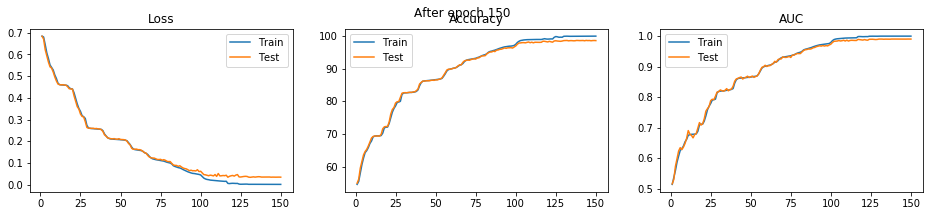

2019-02-12 00:10:08: After epoch 151, TRAIN acc is 99.9989, loss is 0.0008, AUC is 1.0000
2019-02-12 00:11:08: After epoch 151, TEST acc is 98.6300, loss is 0.0341, AUC is 0.9903
2019-02-12 00:21:35: After epoch 152, TRAIN acc is 99.9989, loss is 0.0008, AUC is 1.0000
2019-02-12 00:22:34: After epoch 152, TEST acc is 98.6400, loss is 0.0342, AUC is 0.9903
2019-02-12 00:32:59: After epoch 153, TRAIN acc is 99.9989, loss is 0.0008, AUC is 1.0000
2019-02-12 00:33:58: After epoch 153, TEST acc is 98.6400, loss is 0.0341, AUC is 0.9903
2019-02-12 00:44:29: After epoch 154, TRAIN acc is 99.9989, loss is 0.0008, AUC is 1.0000
2019-02-12 00:45:26: After epoch 154, TEST acc is 98.6000, loss is 0.0342, AUC is 0.9901
2019-02-12 00:55:53: After epoch 155, TRAIN acc is 99.9989, loss is 0.0008, AUC is 1.0000
Epoch   154: reducing learning rate of group 0 to 3.9063e-06.
2019-02-12 00:56:51: After epoch 155, TEST acc is 98.6600, loss is 0.0344, AUC is 0.9901
2019-02-12 01:07:18: After epoch 156, TRAIN

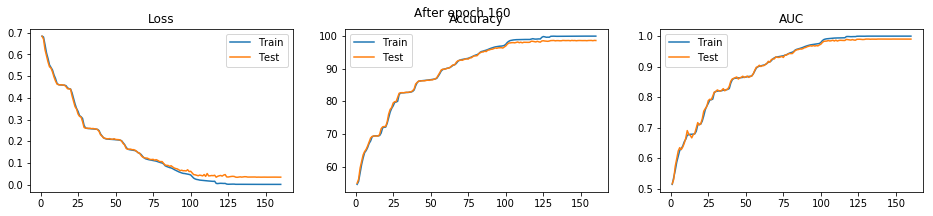

2019-02-12 02:04:27: After epoch 161, TRAIN acc is 99.9989, loss is 0.0008, AUC is 1.0000
Epoch   160: reducing learning rate of group 0 to 1.9531e-06.
2019-02-12 02:05:24: After epoch 161, TEST acc is 98.6400, loss is 0.0340, AUC is 0.9903
2019-02-12 02:15:53: After epoch 162, TRAIN acc is 99.9989, loss is 0.0008, AUC is 1.0000
2019-02-12 02:16:50: After epoch 162, TEST acc is 98.6500, loss is 0.0342, AUC is 0.9903
2019-02-12 02:27:17: After epoch 163, TRAIN acc is 99.9989, loss is 0.0008, AUC is 1.0000
2019-02-12 02:28:15: After epoch 163, TEST acc is 98.6600, loss is 0.0341, AUC is 0.9903
2019-02-12 02:38:34: After epoch 164, TRAIN acc is 99.9989, loss is 0.0008, AUC is 1.0000
2019-02-12 02:39:33: After epoch 164, TEST acc is 98.6500, loss is 0.0343, AUC is 0.9904
2019-02-12 02:49:58: After epoch 165, TRAIN acc is 99.9989, loss is 0.0008, AUC is 1.0000
2019-02-12 02:50:57: After epoch 165, TEST acc is 98.6400, loss is 0.0340, AUC is 0.9903
2019-02-12 03:01:25: After epoch 166, TRAIN

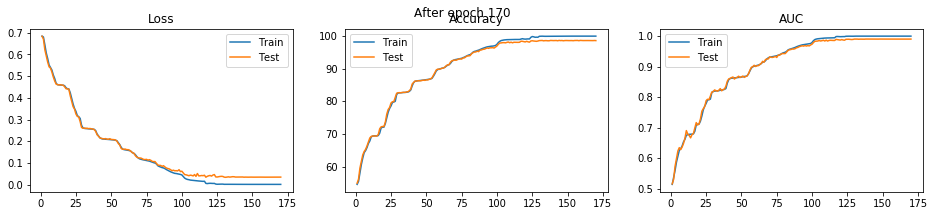

2019-02-12 03:58:30: After epoch 171, TRAIN acc is 99.9989, loss is 0.0008, AUC is 1.0000
2019-02-12 03:59:28: After epoch 171, TEST acc is 98.6800, loss is 0.0341, AUC is 0.9903
2019-02-12 04:09:54: After epoch 172, TRAIN acc is 99.9989, loss is 0.0008, AUC is 1.0000
2019-02-12 04:10:51: After epoch 172, TEST acc is 98.6100, loss is 0.0342, AUC is 0.9902
2019-02-12 04:21:17: After epoch 173, TRAIN acc is 99.9989, loss is 0.0008, AUC is 1.0000
Epoch   172: reducing learning rate of group 0 to 4.8828e-07.
2019-02-12 04:22:15: After epoch 173, TEST acc is 98.6400, loss is 0.0343, AUC is 0.9903


Traceback (most recent call last):
  File "/home/cc/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/cc/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/cc/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/cc/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/cc/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/cc/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/cc/anaconda3/envs/pytorch/lib/python3.7/mult

KeyboardInterrupt: 

In [10]:
total_epochs = 200
wandb.config.update(dict(epochs=total_epochs), allow_val_change=True)

sequential_benchmark(sequential_benchmark_test_model, train_dataloader, test_dataloader, accuracy_threshold,
                     threshold_all_queries=True,
                     num_epochs=total_epochs - current_epoch, epochs_to_graph=10, start_epoch=current_epoch)

1